# Data mining Toronto Fire Incidents Final Report

## Abstract
---
## Objectives
The pipeline achieves the following:

- `Pipeline`
  - `Data_Preprocessing`
    - `Data_cleaning (Ryan)`
      - Drops columns with no relevance.
      - Sanitizes descrepancies for manual input data.
      - Replaces empty strings in categorical columns with `pd.NA`.
      - Drops rows with no values at all according to feature: `Area_of_Origin`.
      - Removes false positives, according to feature: `Final_Incident_Type`
      - Converts non-null values of categorical columns to string to ensure data integrity, ease the imputation processs.
      - Removes outliers using z-score method to eliminate rows that 3 standard deviations from the mean, based on feature, `Estimated_Dollar_Loss`.
      - Replaces values of `NAType` with `np.nan` for numerical columns.
    - `Feature_Engineering` 
      - creates a new feature `Control_Time`. (How long fire burned for.)
      - creates a new feature called `Response_Time`. (How long took for the first arriving unit to get to the incident)
    - `feature_transformers (Ryan)`
      - Applies simple imputer to all categorical features.
      - Applies KNN imputer to all numerical features.
      - Applies ordinal encoding to all categorical features.
      - ~~Applies one hot encoding to categorical features that are not ordinal.~~
      - Standard scale all numerical features.
      - Applies log transformation on response variable.
    - `Feature Selection (Ryan)`
      - Drops features with low Spearman correlation coefficients to response variable.
      - Drops categorical features with low Kruskal-Wallis H-test statistic to response variable.
      - Drops categorical features with low Chi-Squared test statistic to response variable.
      - Removes 4 worst features using `SelectKBest` method with an ANOVA F-test.
  - `model(regressor)` 
    - Linear models
      - Multiple Linear Regression (OLS - Ordinary Least Squares): `(Maurilio)`
      - Lasso (Least Absolute Shrinkage and Selection Operator): `(Maurilio)`
      - Elastic-Net: `(Maurilio)`
      - Huber Regressor:
    - Ensemble methods
      - XGBoost Regressor
    - Non-Linear Models
      - Neural networks (MLP - Multi-layer Perceptron):

### Custom Modules Developed
- data_clean.py

  Classes:
  
  - `DataCleaner`:
  
    **Functions**:
    - `cleanse_dataframe(df)`: Returns a cleansed dataframe.
    

- data_reduction.py

  Classes:
  
  - `FeatureAnalysis`:
  
    **Functions**:
    
    - `keepStrongestFeaturesInDataFrame(responseVariable, df, p_value, correlation)`: Returns a dataframe with features that have a strong correlation and statistical significance to `responseVariable`.
---

## Data Exploration and Visualization
See `src/ExpDataAnalysis.ipynb` and `src/proposal/hypothesis_testing.ipynb`

## Data Preprocessing Pipeline

In [1]:
# Third Party libraries
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

from sklearn.linear_model import LinearRegression

In [2]:
# Load DF
df = pd.read_csv('../../data/raw/Fire_Incidents_Data.csv', low_memory=False)

In [3]:
# Feature Engineering before removing columns

df['Fire_Under_Control_Time'] = pd.to_datetime(df['Fire_Under_Control_Time'])
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

df['Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()
df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()

### Cleanse dataframe.
See modules/data_clean.py, or `Data_Cleaning` section of Pipeline Objectives for more details.

In [4]:
# Import custom Data_cleaning module
from modules.data_clean import DataCleaner

# Cleanse Dataframe
df = DataCleaner.cleanse_dataframe(df)

### Defining all features.
- Numerical Columns
- Categorial Columns
    - Ordinal Columns
    - Onehot Columns

In [5]:
NUMERICAL_COLS = [
    "Civilian_Casualties",
    "Count_of_Persons_Rescued",
    "Estimated_Dollar_Loss",
    "Estimated_Number_Of_Persons_Displaced",
    "Number_of_responding_apparatus",
    "Number_of_responding_personnel",
    "TFS_Firefighter_Casualties",
    "Control_Time", 
    "Response_Time"
]

CATEGORICAL_COLS = ['Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type', 
                'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 
                'Ignition_Source', 'Initial_CAD_Event_Type', 'Material_First_Ignited', 'Method_Of_Fire_Control', 
                'Possible_Cause', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 
                'Smoke_Spread', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'Incident_Ward']

# ['Business_Impact', 'Extent_Of_Fire', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival']
ORDINAL_COLS = CATEGORICAL_COLS[2:4] + CATEGORICAL_COLS[20:22]

# Everything else.
ONEHOT_COLS = list(set(CATEGORICAL_COLS) - set(ORDINAL_COLS))

### Imputation

#### Categorical Imputation

A SimpleImputer is applied to all `CATEGORICAL_COLS`, as it can work with string data types.

In [6]:
# Specify pd.NA as the missing value indicator for SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

# Apply the imputer to the categorical columns
df[CATEGORICAL_COLS] = imputer.fit_transform(df[CATEGORICAL_COLS])

#### Numerical imputation.

A KNN imputer is applied to all `NUMERICAL_COLS` missing data.

In [7]:
import numpy as np

# Replace pd.NA with np.nan
# KNNImputer does not directly support pd.NA
df = df.replace(pd.NA, np.nan)

imputer = KNNImputer()

# Apply the imputer to the categorical columns
df[NUMERICAL_COLS] = imputer.fit_transform(df[NUMERICAL_COLS])

### Categorical Encoding

This will encode all `CATEGORICAL_COLS`.

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np

# Specify ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

# Apply the encoder to specified columns
df[CATEGORICAL_COLS] = ordinal_encoder.fit_transform(df[CATEGORICAL_COLS])

Encoding onehot columns - Work in progress/Not working.

In [9]:


# onehot_encoder = OneHotEncoder(handle_unknown="ignore")
# # Apply the imputer to the categorical columns
# df_encoded= onehot_encoder.fit_transform(df[ONEHOT_COLS])

# df_encoded

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LinearRegression

# # X is a numpy array with your features
# # y is the label array
# enc = OneHotEncoder(sparse=False)
# X_transform = enc.fit_transform(X)

# # apply your linear regression as you want
# model = LinearRegression()
# model.fit(X_transform, y)

# print("Mean squared error: %.2f" % np.mean((model.predict(X_transform) - y) ** 2))

### Standard scaler on numerical Data

Apply standard scaling to all `NUMERICAL_COLS`.
Standardizes features by removing the mean and scaling to unit variance to create a normal distribution.
Many models may assume normally distributed data.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

### Log transform response variable.
Log transform the `responseVariable`, to improve heteroskedasticity (make the residual variance appear more constant) and normality (reduce the skewness of the data). 

In [11]:
# Log transform the Estimated_Dollar_Loss column
df['Estimated_Dollar_Loss'] = np.log(df['Estimated_Dollar_Loss'] + 1)  # Adding 1 to avoid log(0) issue

### Feature Selection (Part 1)
Select features based on the following:
- Spearman correlation coefficients with p-values for each categorical feature.
- Kruskal-Wallis H-test statistic for each categorical feature
- Calculate Chi-Squared test statistic for each categorical feature

Using these values, a measure of `p-value` and `correlation` is developed for each column against the response variable.

Columns are kept so long as its `(['P-value'] < 0.1) & (['Correlation'] > 0.003)`.

This will drop the following features: {'Final_Incident_Type', 'Smoke_Alarm_at_Fire_Origin'}. Increasing the correlation threshold any more will drop more features and will result in a worse r-sq.

In [12]:
# Import Data_reduction module
from modules.data_reduction import FeatureAnalysis

# helper function that will drop low correlated variables in the dataset
df_reduced = FeatureAnalysis.keepStrongestFeaturesInDataFrame('Estimated_Dollar_Loss', df, 0.1, 0.003)

### Train test split

In [13]:
from sklearn.model_selection import train_test_split
df = df_reduced
# List all columns in the DataFrame
all_columns = df.columns.tolist()

# Use every other column in the df except for the response variable
features = [col for col in all_columns if col != 'Estimated_Dollar_Loss']

# Separate features from response variable
X, y = df[features], df['Estimated_Dollar_Loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

### Feature Selection (Part 2)

Perform feature selection using the SelectKBest method from with an ANOVA F-test (f_classif). It then removes the worst four features from both the training and testing sets.

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection using SelectKBest with ANOVA F-test
k_best_features = SelectKBest(score_func=f_classif, k=X_train.shape[1]) # Select all features initially
X_train_selected = k_best_features.fit_transform(X_train, y_train)

# Get the scores and indices of the features
feature_scores = k_best_features.scores_

# Get a list of indexes based on the value of the index's element. Sorted.
# The list of indexes is generated by the range function. (len(feature_scores))
feature_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)

# Identify the worst four features to remove
features_to_remove = [feature_indices[-1], feature_indices[-2], feature_indices[-3], feature_indices[-4]]

# remove the worst four features from both training and testing sets
X_train = X_train.drop(X_train.columns[features_to_remove], axis=1)
X_test = X_test.drop(X_test.columns[features_to_remove], axis=1)


---
## Modelling Implementation and Evaluation

### Helper Functions

In [15]:
# Function: Print Results of a Model (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT).
def print_results(r2, mae, mse, coefficients, intercept):
    print(f"R-squared score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")

# Function: Return Results (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def get_results(model, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    coefficients = model.coef_
    intercept = model.intercept_
    return (r2, mae, mse, coefficients, intercept)

# Function: Plot Scatter plot for regression model. (y_pred = lr.predict(X_test), R2 Score)
import matplotlib.pyplot as plt
import seaborn as sns
def plotRegression(y_pred, r2):
    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')  # Identity line
    plt.title('Actual vs. Predicted (Regression)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Annotate plot with R-squared value
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')

    plt.show()

### Linear Regression

---------MLR----------
R-squared score: 0.5005
Mean Absolute Error: 0.18855416108801634
Mean Squared Error: 0.09082654811349444
Coefficients: [-6.03237515e-04  9.07617670e-03  2.20463029e-02  4.03249487e-03
  2.95734300e-02  3.52263677e-02  5.40422886e-03  2.63843115e-03
  1.43456053e-02 -5.32225358e-05  1.63343605e-03 -1.87189687e-02
 -1.40112864e-01  3.27864841e-01  1.83400740e-03  1.98049938e-04
  1.03167919e-02  2.07188823e-03 -2.73848219e-03  3.44884662e-03
  1.31544149e-03 -1.82642147e-02  3.15689721e-02  2.08844500e-02
  2.22179295e-02]
Intercept: -0.517010116248453


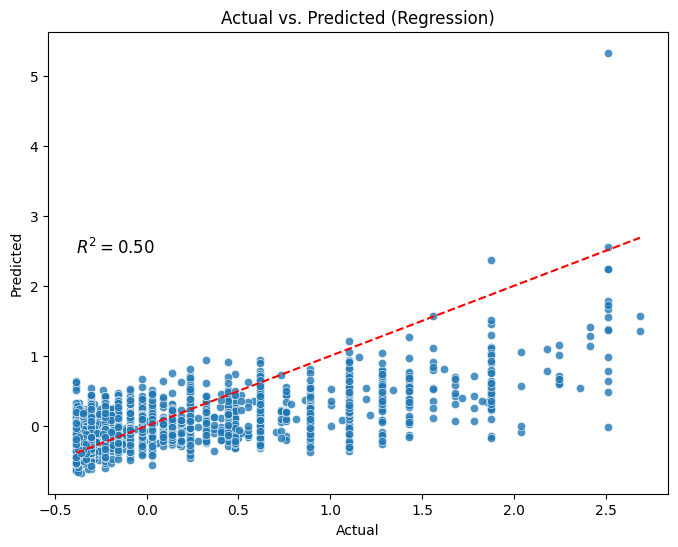

----------------------


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression() # to do - settings hyperparameters 
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
residuals_lr = y_test - y_pred_lr

(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr) = get_results(lr, y_test, y_pred_lr)

# Results - Another option would be to use statsmodels to display a summary
print("---------MLR----------")
print_results(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr)
plotRegression(y_pred_lr, r2_lr)
print("----------------------")

### Lasso Regression

---------LASSO----------
R-squared score: 0.0050
Mean Absolute Error: 0.27546187522614746
Mean Squared Error: 0.18093335069258049
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.00015448  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.12569878120827602
------------------------
---------LASSO CV BEST----------
R-squared score: 0.4902
Mean Absolute Error: 0.1870998903408478
Mean Squared Error: 0.09271636404302167
Coefficients: [-4.43928675e-04  8.10169938e-03  9.28989271e-03  0.00000000e+00
  2.24547034e-02  3.58710302e-02  3.47166606e-03  0.00000000e+00
  4.34747804e-03 -2.58207933e-05  1.67300008e-03 -1.14196740e-02
  1.55946271e-01  3.16098038e-02  2.21873756e-03  1.54448249e-04
  8.77290506e-03  0.00000000e+00  0.00000000e+00  3.04083041e-03
 -0.00000000e+00 -0.00000000e+00  3.03908328e-02 

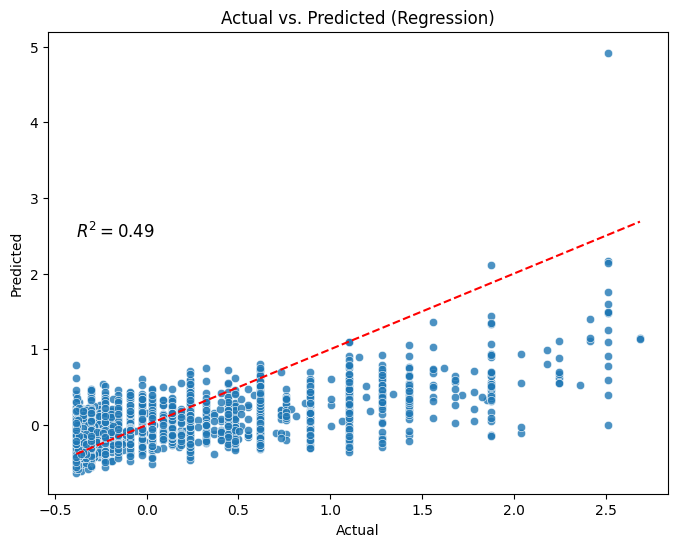

---------------------------


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Need to scale before using Lasso. I am not sure if we've already done in preprocessing
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# Lasso Model 1 = basic

lasso = Lasso(tol=0.05)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso) = get_results(lasso, y_test, y_pred_lasso)

print("---------LASSO----------")
print_results(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso)
print("------------------------")

# Lasso Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]	
}

lasso_cv = GridSearchCV(lasso, param_grid, cv=3, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

# Get the Lasso with the best estimators
lasso_best = lasso_cv.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test)
(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best) = get_results(lasso_best, y_test, y_pred_lasso_best)

print("---------LASSO CV BEST----------")
print_results(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best)
plotRegression(y_pred_lasso_best, r2_lasso_best)
print("---------------------------")